In [1]:
from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics 8.3.40  Python-3.11.5 torch-2.5.1+cpu CPU (AMD Ryzen 7 6800HS with Radeon Graphics)
Setup complete  (16 CPUs, 15.2 GB RAM, 830.0/930.6 GB disk)


In [2]:
from ultralytics import YOLO
import pandas as pd
from IPython.display import display, Image
import shutil

import os
import re
import json
from pylabel import importer
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
pd.set_option('display.max_columns', None)


In [3]:
HOME = os.getcwd()
train_path = "../../data/processed_version/processed_train"
# valid_path = "../../data/material_version/val"

train_annots = "../../data/processed_version/instances_processed_train_trashcan.json"
# valid_annots = "../../data/material_version/instances_val_trashcan.json"

destination_path = f"{HOME}/destination"

results = "reports/results"

In [4]:
class ScriptUtilities:
    @staticmethod
    def json_viewer(annots_json):
        # Read the JSON file
        with open(annots_json, 'r') as file:
            annotations_data = json.load(file)

        # Display information for the top 5 images
        for image_info in annotations_data['images'][:5]:
            print(f"Image ID: {image_info['id']}")
            print(f"File Name: {image_info['file_name']}")
            print(f"Height: {image_info['height']}, Width: {image_info['width']}")
            print(f"Date Captured: {image_info['date_captured']}")
            print("----------------------")

        # View content under 'annotations' key
        if 'annotations' in annotations_data:
            print("Annotations:")
            for annotation in annotations_data['annotations'][:5]:
                print(annotation)
                print("----------------------")
        else:
            print("No 'annotations' key found in the JSON data.")

    @staticmethod
    def json_tree(annots_json):
        # Read the JSON file
        with open(annots_json, 'r') as file:
            annotations_data = json.load(file)
        # Print the keys at the top level of the JSON structure
        print(annotations_data.keys())

    @staticmethod
    def coco_to_yolo_converter(annots_json, path_to_images, name):
        dataset = importer.ImportCoco(annots_json, path_to_images=path_to_images, name=name)

        return dataset

In [5]:
# Train dataset
train_dataset = ScriptUtilities.coco_to_yolo_converter(train_annots, train_path, name="BCCD_train_coco")

# Valid dataset
# valid_dataset = ScriptUtilities.coco_to_yolo_converter(valid_annots, valid_path, name="BCCD_valid_coco")

In [6]:
train_dataset.df.sample(5)


,img_folder,img_filename,img_path,img_id,img_width,img_height,img_depth,ann_segmented,ann_bbox_xmin,ann_bbox_ymin,ann_bbox_xmax,ann_bbox_ymax,ann_bbox_width,ann_bbox_height,ann_area,ann_segmentation,ann_iscrowd,ann_keypoints,ann_pose,ann_truncated,ann_difficult,cat_id,cat_name,cat_supercategory,split,annotated
id,,,,,,,,,,,,,,,,,,,,,,,,,,
5443,../../data/processed_version/processed_train,vid_000148_frame0000029.jpg,,3352,480,360,,,63.001961,102.001961,379.000000,291.998039,315.998039,189.996078,53026.384321,"[[361.0, 291.9980392156863, 361.0, 290.0019607...",0,,,,,11,trash_fishing_gear,trash_fishing_gear,,1
1266,../../data/processed_version/processed_train,vid_000291_frame0000081.jpg,,784,480,360,,,0.001961,84.001992,222.997630,360.995652,222.995670,276.993660,36753.486638,"[[222.0, 360.995652173913, 222.99763033175356,...",0,,,,,1,rov,rov,,1
1152,../../data/processed_version/processed_train,vid_000150_frame0000048.jpg,,714,480,360,,,13.001961,0.001961,410.998039,359.998039,397.996078,359.996078,80853.875521,"[[410.0, 359.9980392156863, 410.9980392156863,...",0,,,,,9,trash_etc,trash_etc,,1
143,../../data/processed_version/processed_train,vid_000440_frame0000045.jpg,,99,480,270,,,102.001961,66.001961,319.995575,203.500000,217.993614,137.498039,18708.687779,"[[293.0, 203.5, 302.0, 201.9, 312.0, 196.98, 3...",0,,,,,3,animal_fish,animal_fish,,1
9479,../../data/processed_version/processed_train,vid_000140_frame0000004.jpg,,5860,480,270,,,187.002451,176.009804,238.993827,198.994949,51.991376,22.985146,936.870073,"[[228.0, 198.99382716049382, 234.0, 196.981481...",0,,,,,12,trash_metal,trash_metal,,1


In [7]:
# valid_dataset.df.sample(5)

In [8]:
# dataset_list = [train_dataset, valid_dataset]

# for dataset in dataset_list:
#     print("\n")
#     print(f"Number of images: {dataset.analyze.num_images}")
#     print(f"Number of classes: {dataset.analyze.num_classes}")
#     print(f"Classes:{dataset.analyze.classes}")
#     print(f"Class counts:\n{dataset.analyze.class_counts}")
#     print(f"Path to annotations:\n{dataset.path_to_annotations}")

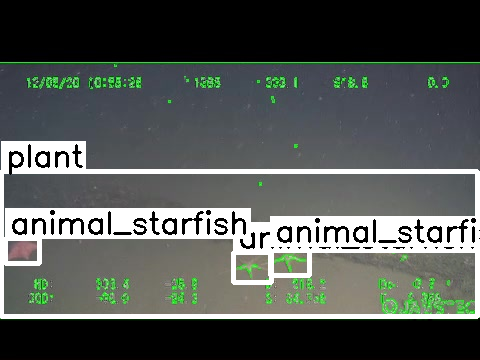

In [9]:
display(train_dataset.visualize.ShowBoundingBoxes(2))

In [ ]:
train_dataset.export.ExportToYoloV5(output_path = f'{destination_path}/training/labels',
                              copy_images = True,
                              yaml_file = "dataset.yaml",
                              segmentation = True)

Exporting YOLO files...: 100%|██████████| 6008/6008 [00:56<00:00, 106.97it/s]


['c:\\Users\\ASUS\\OneDrive\\Desktop\\marine-debris-detection\\src\\models\\destination\\training\\dataset.yaml',
 'c:\\Users\\ASUS\\OneDrive\\Desktop\\marine-debris-detection\\src\\models\\destination\\training\\labels\\vid_000421_frame0000005.txt',
 'c:\\Users\\ASUS\\OneDrive\\Desktop\\marine-debris-detection\\src\\models\\destination\\training\\labels\\vid_000106_frame0000015.txt',
 'c:\\Users\\ASUS\\OneDrive\\Desktop\\marine-debris-detection\\src\\models\\destination\\training\\labels\\vid_000158_frame0000044.txt',
 'c:\\Users\\ASUS\\OneDrive\\Desktop\\marine-debris-detection\\src\\models\\destination\\training\\labels\\vid_000044_frame0000021.txt',
 'c:\\Users\\ASUS\\OneDrive\\Desktop\\marine-debris-detection\\src\\models\\destination\\training\\labels\\vid_000437_frame0000015.txt',
 'c:\\Users\\ASUS\\OneDrive\\Desktop\\marine-debris-detection\\src\\models\\destination\\training\\labels\\vid_000132_frame0000098.txt',
 'c:\\Users\\ASUS\\OneDrive\\Desktop\\marine-debris-detection\\s

In [11]:
# valid_dataset.export.ExportToYoloV5(output_path = f'{destination_path}/valid/labels',
#                               copy_images = True,
#                               yaml_file = "dataset.yaml",
#                               segmentation = True)

In [12]:
# Note!!! Only run this code once
path = f"destination/training/labels" #path of labels
labels = os.listdir(path)
for x in labels:
    lines = list()
    with open(path+"/"+x, "r+") as f:
        for line in f.read().splitlines():
            split_line = line.split(" ")  # split on space character (and remove newline characters as well)
            split_line[0] = str(
              int(split_line[0]) - 1)  # update the value inside the loop. the loop used in later not needed.
            lines.append(split_line)  # add split list into list of lines

    with open(path+"/"+x, 'w') as file:  # rewrite to file
        for line in lines:
            write_me = ' '.join(line)  # Use join method to add the element together
            file.write(write_me + "\n")

# Code adapted from: hhttps://www.kaggle.com/code/vencerlanz09/insect-images-classification-using-yolov5

In [13]:
# # Note!!! Only run this code once
# path = f"destination/valid/labels" #path of labels
# labels = os.listdir(path)
# for x in labels:
#     lines = list()
#     with open(path+"/"+x, "r+") as f:
#         for line in f.read().splitlines():
#             split_line = line.split(" ")  # split on space character (and remove newline characters as well)
#             split_line[0] = str(
#               int(split_line[0]) - 1)  # update the value inside the loop. the loop used in later not needed.
#             lines.append(split_line)  # add split list into list of lines

#     with open(path+"/"+x, 'w') as file:  # rewrite to file
#         for line in lines:
#             write_me = ' '.join(line)  # Use join method to add the element together
#             file.write(write_me + "\n")

# # Code adapted from: hhttps://www.kaggle.com/code/vencerlanz09/insect-images-classification-using-yolov5

In [14]:
os.environ["WANDB_MODE"]="offline"

In [15]:
!rm -f ../destination/training/labels.cache

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [16]:
# import requests

# url = "https://github.com/ultralytics/assets/releases/download/v8.1.0/yolov8n-seg.pt"
# output_path = "yolov8n-seg.pt"

# response = requests.get(url, stream=True)
# if response.status_code == 200:
#     with open(output_path, "wb") as f:
#         f.write(response.content)
#     print(f"Downloaded {output_path}")
# else:
#     print(f"Failed to download file. Status code: {response.status_code}")


In [ ]:
# Load a model
model = YOLO(f"yolov8n-seg.pt")  # load a pretrained model (recommended for training)

In [18]:
# Train the model
results = model.train(data=f"destination/training/dataset.yaml", epochs=35, imgsz=(480, 270))

New https://pypi.org/project/ultralytics/8.3.44 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.40  Python-3.11.5 torch-2.5.1+cpu CPU (AMD Ryzen 7 6800HS with Radeon Graphics)
engine\trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=destination/training/dataset.yaml, epochs=35, time=None, patience=100, batch=16, imgsz=(480, 270), save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train23, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, em

train: Scanning C:\Users\ASUS\OneDrive\Desktop\marine-debris-detection\src\models\destination\training\labels.cache... 6008 images, 0 backgrounds, 193 corrupt: 100%|██████████| 6008/6008 [00:00<?, ?it/s]

train: WARNING  C:\Users\ASUS\OneDrive\Desktop\marine-debris-detection\src\models\destination\training\images\vid_000052_frame0000054.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0037]
train: WARNING  C:\Users\ASUS\OneDrive\Desktop\marine-debris-detection\src\models\destination\training\images\vid_000052_frame0000056.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0037      1.0037]
train: WARNING  C:\Users\ASUS\OneDrive\Desktop\marine-debris-detection\src\models\destination\training\images\vid_000052_frame0000058.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0037      1.0037]
train: WARNING  C:\Users\ASUS\OneDrive\Desktop\marine-debris-detection\src\models\destination\training\images\vid_000052_frame0000060.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0021      1.0037]
train: WARNING  C:\Users\ASUS\OneDrive\Desktop\marine-de


val: Scanning C:\Users\ASUS\OneDrive\Desktop\marine-debris-detection\src\models\destination\training\labels.cache... 6008 images, 0 backgrounds, 193 corrupt: 100%|██████████| 6008/6008 [00:00<?, ?it/s]

train: WARNING  C:\Users\ASUS\OneDrive\Desktop\marine-debris-detection\src\models\destination\training\images\vid_000052_frame0000054.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0037]
train: WARNING  C:\Users\ASUS\OneDrive\Desktop\marine-debris-detection\src\models\destination\training\images\vid_000052_frame0000056.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0037      1.0037]
train: WARNING  C:\Users\ASUS\OneDrive\Desktop\marine-debris-detection\src\models\destination\training\images\vid_000052_frame0000058.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0037      1.0037]
train: WARNING  C:\Users\ASUS\OneDrive\Desktop\marine-debris-detection\src\models\destination\training\images\vid_000052_frame0000060.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0021      1.0037]
train: WARNING  C:\Users\ASUS\OneDrive\Desktop\marine-de

Plotting labels to runs\segment\train23\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.0005, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 480 train, 480 val
Using 0 dataloader workers
Logging results to runs\segment\train23
Starting training for 35 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/35         0G      1.423      2.829      3.434      1.317         25        480: 100%|██████████| 364/364 [12:50<00:00,  2.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [03:46<00:00,  1.25s/it]


                   all       5815       9323      0.543       0.22      0.185      0.121      0.546      0.212      0.181      0.106

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/35         0G      1.349      2.401      2.534       1.27         17        480: 100%|██████████| 364/364 [11:55<00:00,  1.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [03:50<00:00,  1.27s/it]


                   all       5815       9323      0.454      0.295      0.276      0.174       0.53      0.289      0.274      0.159

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/35         0G      1.329      2.349      2.304      1.261         31        480: 100%|██████████| 364/364 [11:37<00:00,  1.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [03:44<00:00,  1.23s/it]


                   all       5815       9323      0.691      0.318      0.356      0.231      0.693      0.319      0.356      0.203

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/35         0G      1.303      2.255      2.079      1.241         14        480: 100%|██████████| 364/364 [11:38<00:00,  1.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [03:44<00:00,  1.23s/it]


                   all       5815       9323      0.697      0.366      0.411      0.252      0.696      0.363      0.406      0.221

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/35         0G      1.264      2.194       1.91       1.22         22        480: 100%|██████████| 364/364 [11:39<00:00,  1.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [03:39<00:00,  1.20s/it]


                   all       5815       9323      0.606      0.435      0.479      0.313      0.603      0.431      0.472       0.27

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/35         0G      1.234      2.119      1.787      1.201         35        480: 100%|██████████| 364/364 [11:36<00:00,  1.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [03:33<00:00,  1.17s/it]


                   all       5815       9323      0.637      0.484      0.525      0.353      0.639      0.471      0.513      0.305

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/35         0G      1.199      2.069      1.644      1.183         26        480: 100%|██████████| 364/364 [11:37<00:00,  1.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [03:31<00:00,  1.16s/it]


                   all       5815       9323      0.628      0.565      0.604      0.395      0.623       0.56      0.593      0.343

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/35         0G       1.18      2.027      1.564      1.179         12        480: 100%|██████████| 364/364 [11:37<00:00,  1.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [03:25<00:00,  1.13s/it]


                   all       5815       9323      0.708      0.554      0.619      0.427      0.712      0.538        0.6      0.355

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/35         0G       1.15      1.972      1.476      1.158         14        480: 100%|██████████| 364/364 [11:39<00:00,  1.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [03:22<00:00,  1.11s/it]


                   all       5815       9323      0.708      0.573       0.65       0.45      0.697       0.56      0.634      0.379

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/35         0G      1.137      1.926      1.409      1.151         23        480: 100%|██████████| 364/364 [11:40<00:00,  1.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [03:23<00:00,  1.12s/it]


                   all       5815       9323      0.693      0.623      0.684      0.471      0.691      0.611      0.671      0.398

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/35         0G      1.115      1.893      1.346      1.134         19        480: 100%|██████████| 364/364 [11:52<00:00,  1.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [03:40<00:00,  1.21s/it]


                   all       5815       9323      0.755      0.633       0.71      0.488      0.752       0.62      0.692      0.419

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/35         0G      1.111      1.871      1.293      1.137         35        480: 100%|██████████| 364/364 [12:27<00:00,  2.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [03:48<00:00,  1.26s/it]


                   all       5815       9323      0.776      0.666      0.746      0.517      0.766      0.658       0.73      0.441

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/35         0G      1.073      1.822      1.239      1.117         24        480: 100%|██████████| 364/364 [12:54<00:00,  2.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [03:34<00:00,  1.18s/it]


                   all       5815       9323      0.726      0.691       0.73      0.505       0.72      0.681      0.713      0.425

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/35         0G      1.064      1.807      1.219      1.111         17        480: 100%|██████████| 364/364 [12:15<00:00,  2.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [03:38<00:00,  1.20s/it]


                   all       5815       9323      0.754      0.708      0.761      0.532      0.747      0.693      0.747      0.453

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/35         0G      1.054      1.782      1.183      1.106         24        480: 100%|██████████| 364/364 [12:40<00:00,  2.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [03:35<00:00,  1.18s/it]


                   all       5815       9323      0.812      0.727      0.788       0.56      0.808      0.718      0.771      0.476

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/35         0G       1.04      1.755      1.147      1.097         25        480: 100%|██████████| 364/364 [12:41<00:00,  2.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [03:38<00:00,  1.20s/it]


                   all       5815       9323      0.797      0.731      0.801      0.561      0.793      0.724      0.785      0.472

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/35         0G      1.037      1.739      1.108      1.093         25        480: 100%|██████████| 364/364 [12:32<00:00,  2.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [03:36<00:00,  1.19s/it]


                   all       5815       9323      0.824      0.721      0.807      0.576      0.809      0.712      0.783      0.471

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/35         0G      1.014      1.691      1.084      1.084         15        480: 100%|██████████| 364/364 [12:22<00:00,  2.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [03:29<00:00,  1.15s/it]


                   all       5815       9323      0.815      0.741      0.803       0.58       0.81      0.733      0.788      0.486

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/35         0G      1.007      1.709      1.058      1.079         26        480: 100%|██████████| 364/364 [12:32<00:00,  2.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [03:32<00:00,  1.17s/it]


                   all       5815       9323      0.826      0.757      0.826      0.596      0.819      0.741      0.806      0.488

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/35         0G          1      1.679      1.032      1.075         29        480: 100%|██████████| 364/364 [12:33<00:00,  2.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [03:32<00:00,  1.17s/it]


                   all       5815       9323      0.829       0.76      0.824      0.598      0.829      0.739      0.804      0.496

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/35         0G      0.989      1.649       1.01       1.07         14        480: 100%|██████████| 364/364 [12:32<00:00,  2.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [03:32<00:00,  1.17s/it]


                   all       5815       9323       0.84       0.79      0.854      0.624      0.823      0.783      0.835      0.521

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/35         0G     0.9817      1.631     0.9876      1.066         22        480: 100%|██████████| 364/364 [12:32<00:00,  2.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [03:31<00:00,  1.16s/it]


                   all       5815       9323      0.831       0.79      0.851      0.623      0.824      0.775       0.83      0.516

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/35         0G     0.9646      1.636     0.9649      1.059         24        480: 100%|██████████| 364/364 [12:32<00:00,  2.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [03:33<00:00,  1.17s/it]


                   all       5815       9323      0.842      0.788      0.859      0.632      0.835      0.775      0.838      0.524

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/35         0G     0.9539       1.62     0.9513      1.054         15        480: 100%|██████████| 364/364 [12:21<00:00,  2.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [03:19<00:00,  1.10s/it]


                   all       5815       9323       0.86        0.8      0.867      0.637      0.848      0.783      0.846       0.53

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/35         0G     0.9466      1.586     0.9291      1.049         28        480: 100%|██████████| 364/364 [11:59<00:00,  1.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [03:36<00:00,  1.19s/it]


                   all       5815       9323       0.85      0.807      0.874      0.647      0.836      0.792      0.854      0.538
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/35         0G     0.8906      1.476     0.7952      1.015          9        480: 100%|██████████| 364/364 [12:22<00:00,  2.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [03:30<00:00,  1.15s/it]


                   all       5815       9323       0.84      0.799      0.866      0.638      0.835      0.786       0.85      0.535

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/35         0G     0.8709      1.454     0.7506      1.008          9        480: 100%|██████████| 364/364 [12:04<00:00,  1.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [03:31<00:00,  1.16s/it]


                   all       5815       9323      0.864      0.805      0.879      0.649       0.85      0.791      0.856      0.535

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/35         0G      0.861      1.431     0.7238     0.9977          8        480: 100%|██████████| 364/364 [11:45<00:00,  1.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [03:19<00:00,  1.10s/it]


                   all       5815       9323      0.866      0.825      0.889      0.661       0.86      0.808      0.866      0.547

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/35         0G     0.8446      1.417     0.7038     0.9925         17        480: 100%|██████████| 364/364 [11:30<00:00,  1.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [03:20<00:00,  1.10s/it]

                   all       5815       9323      0.881      0.834      0.897      0.673      0.855      0.829      0.877      0.556



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/35         0G     0.8275      1.392     0.6856     0.9833         11        480: 100%|██████████| 364/364 [11:29<00:00,  1.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [03:19<00:00,  1.10s/it]

                   all       5815       9323      0.876      0.838        0.9      0.676       0.87      0.822       0.88       0.56



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      31/35         0G     0.8211      1.376     0.6665     0.9784         10        480: 100%|██████████| 364/364 [11:28<00:00,  1.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [03:20<00:00,  1.10s/it]

                   all       5815       9323       0.89      0.837      0.906      0.681      0.878      0.825      0.888      0.565



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      32/35         0G     0.8137      1.374     0.6555     0.9775         14        480: 100%|██████████| 364/364 [11:31<00:00,  1.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [03:20<00:00,  1.10s/it]

                   all       5815       9323       0.88      0.843      0.905      0.685      0.868       0.83      0.884      0.564



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      33/35         0G      0.806      1.358     0.6401     0.9731         23        480: 100%|██████████| 364/364 [11:29<00:00,  1.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [03:19<00:00,  1.10s/it]

                   all       5815       9323      0.883       0.85      0.907       0.69       0.87       0.84       0.89       0.57



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      34/35         0G     0.7953       1.34     0.6338     0.9681          8        480: 100%|██████████| 364/364 [11:30<00:00,  1.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [03:19<00:00,  1.10s/it]

                   all       5815       9323      0.879      0.856       0.91      0.695      0.864      0.839      0.887       0.57



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      35/35         0G     0.7853      1.339     0.6202      0.963          9        480: 100%|██████████| 364/364 [11:24<00:00,  1.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [03:17<00:00,  1.09s/it]

                   all       5815       9323       0.88      0.865      0.914      0.699      0.867       0.85      0.895      0.575



35 epochs completed in 9.087 hours.
Optimizer stripped from runs\segment\train23\weights\last.pt, 6.8MB
Optimizer stripped from runs\segment\train23\weights\best.pt, 6.8MB

Validating runs\segment\train23\weights\best.pt...
Ultralytics 8.3.40  Python-3.11.5 torch-2.5.1+cpu CPU (AMD Ryzen 7 6800HS with Radeon Graphics)
YOLOv8n-seg summary (fused): 195 layers, 3,261,184 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [02:47<00:00,  1.09it/s]


                   all       5815       9323      0.879      0.865      0.914      0.699      0.866       0.85      0.895      0.575
                   rov       2136       2517      0.919      0.883      0.946      0.848      0.918      0.882      0.944      0.737
                 plant        371        392      0.945      0.913      0.949      0.682      0.932      0.901      0.926      0.539
           animal_fish        528        595      0.964      0.862      0.946      0.792      0.959      0.857      0.941       0.71
       animal_starfish         74        190      0.588      0.826      0.808      0.478      0.526      0.737      0.671      0.233
         animal_shells         99        171      0.821      0.563      0.709      0.432      0.795      0.545      0.685      0.355
           animal_crab        145        245      0.826      0.845      0.886      0.629      0.819      0.837      0.884      0.465
            animal_eel        184        266       0.85      0.808   

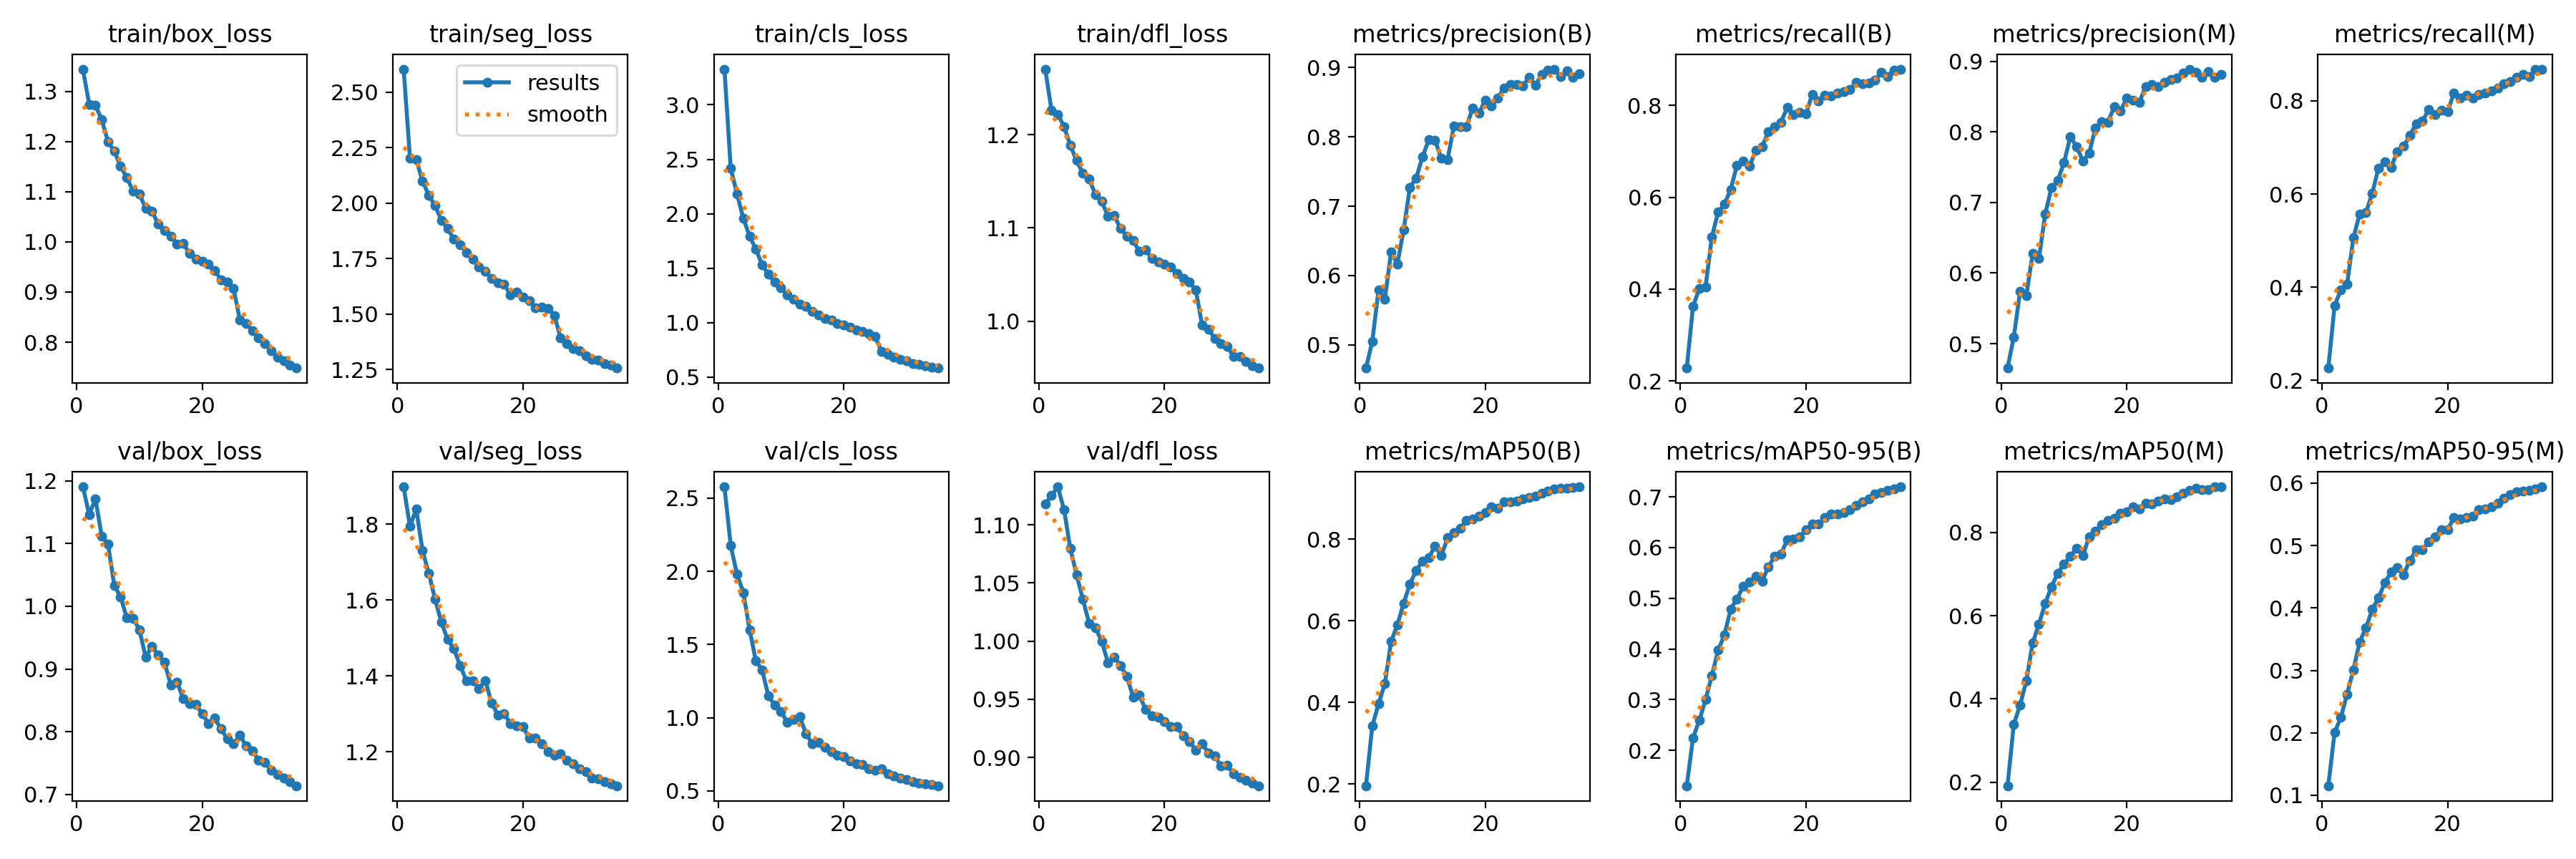

In [19]:
# Path to the PNG file
result_png_path = "../models/runs/segment/train21/results.png"

# Display the PNG file
Image(result_png_path)


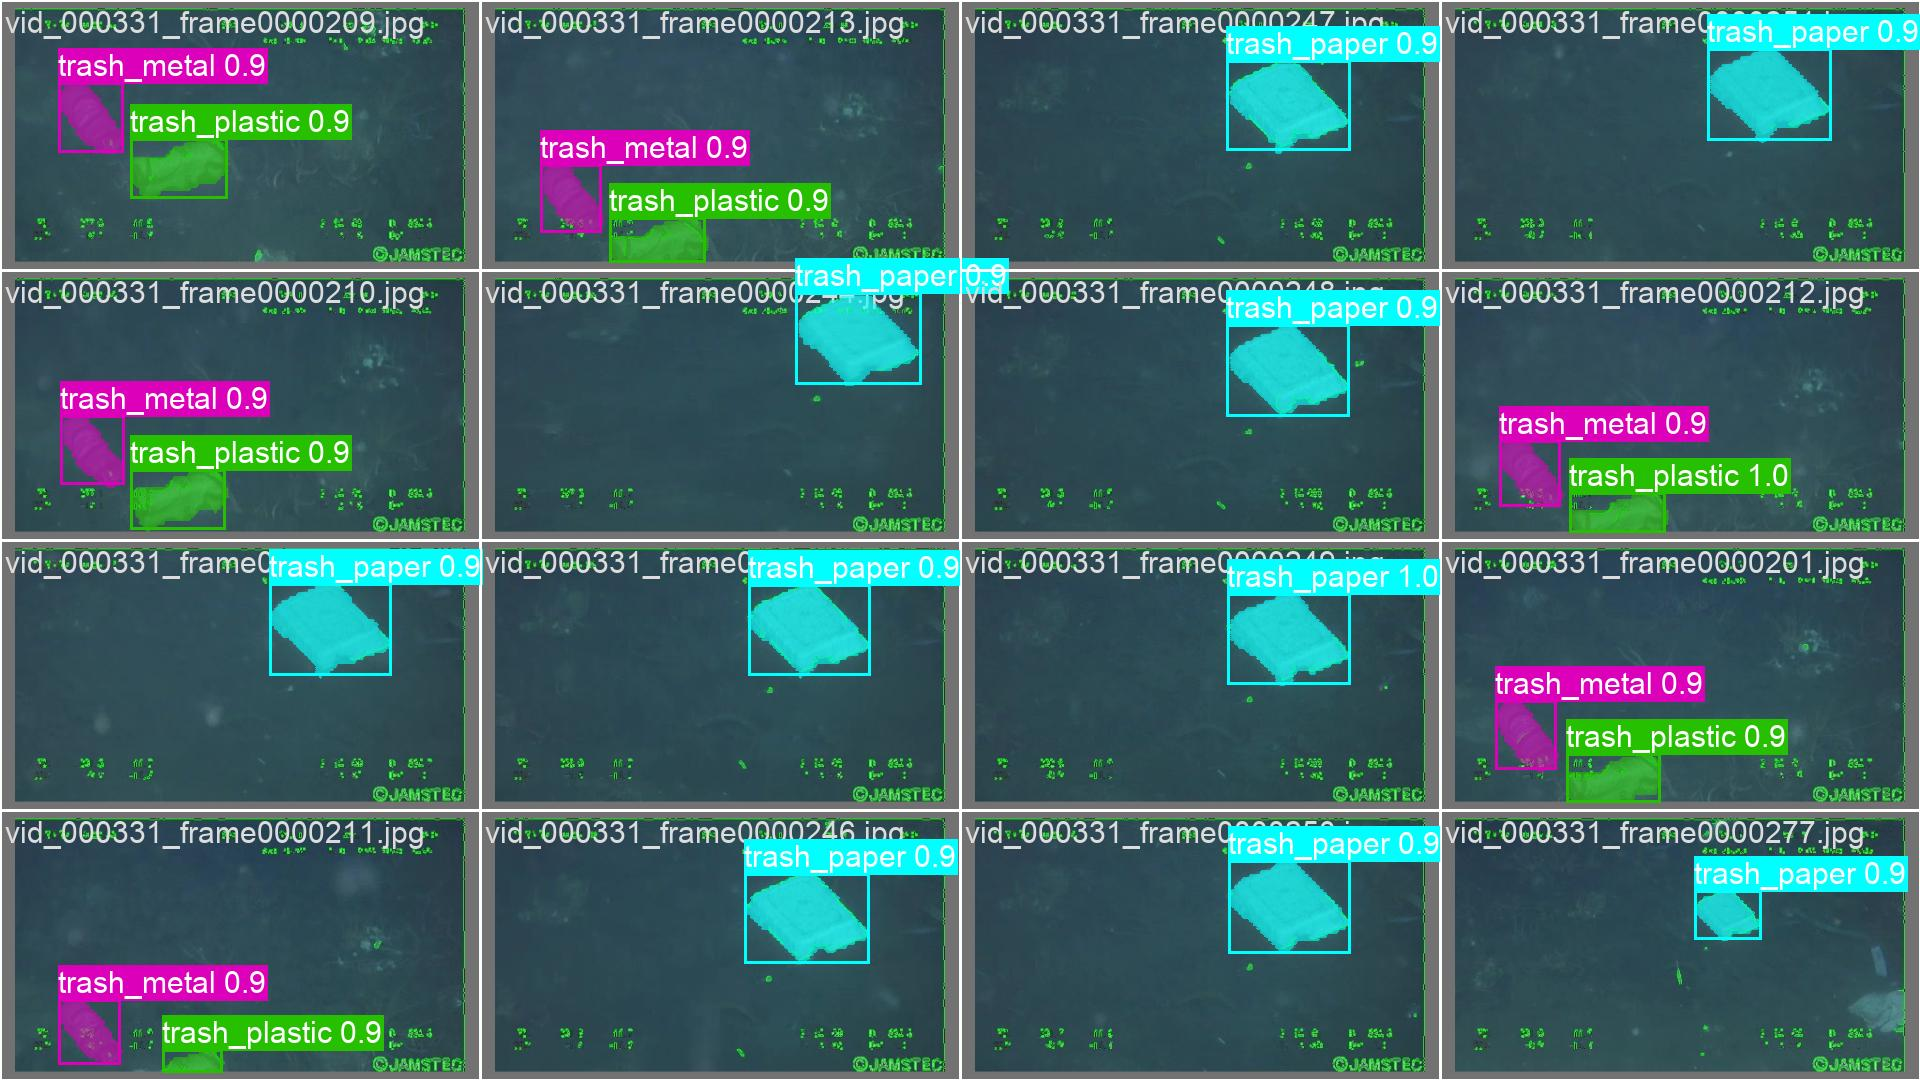

In [27]:
# Path to the PNG file
result_png_path = f"{HOME}/runs/segment/train23/val_batch1_pred.jpg"

# Display the PNG file
Image(result_png_path)

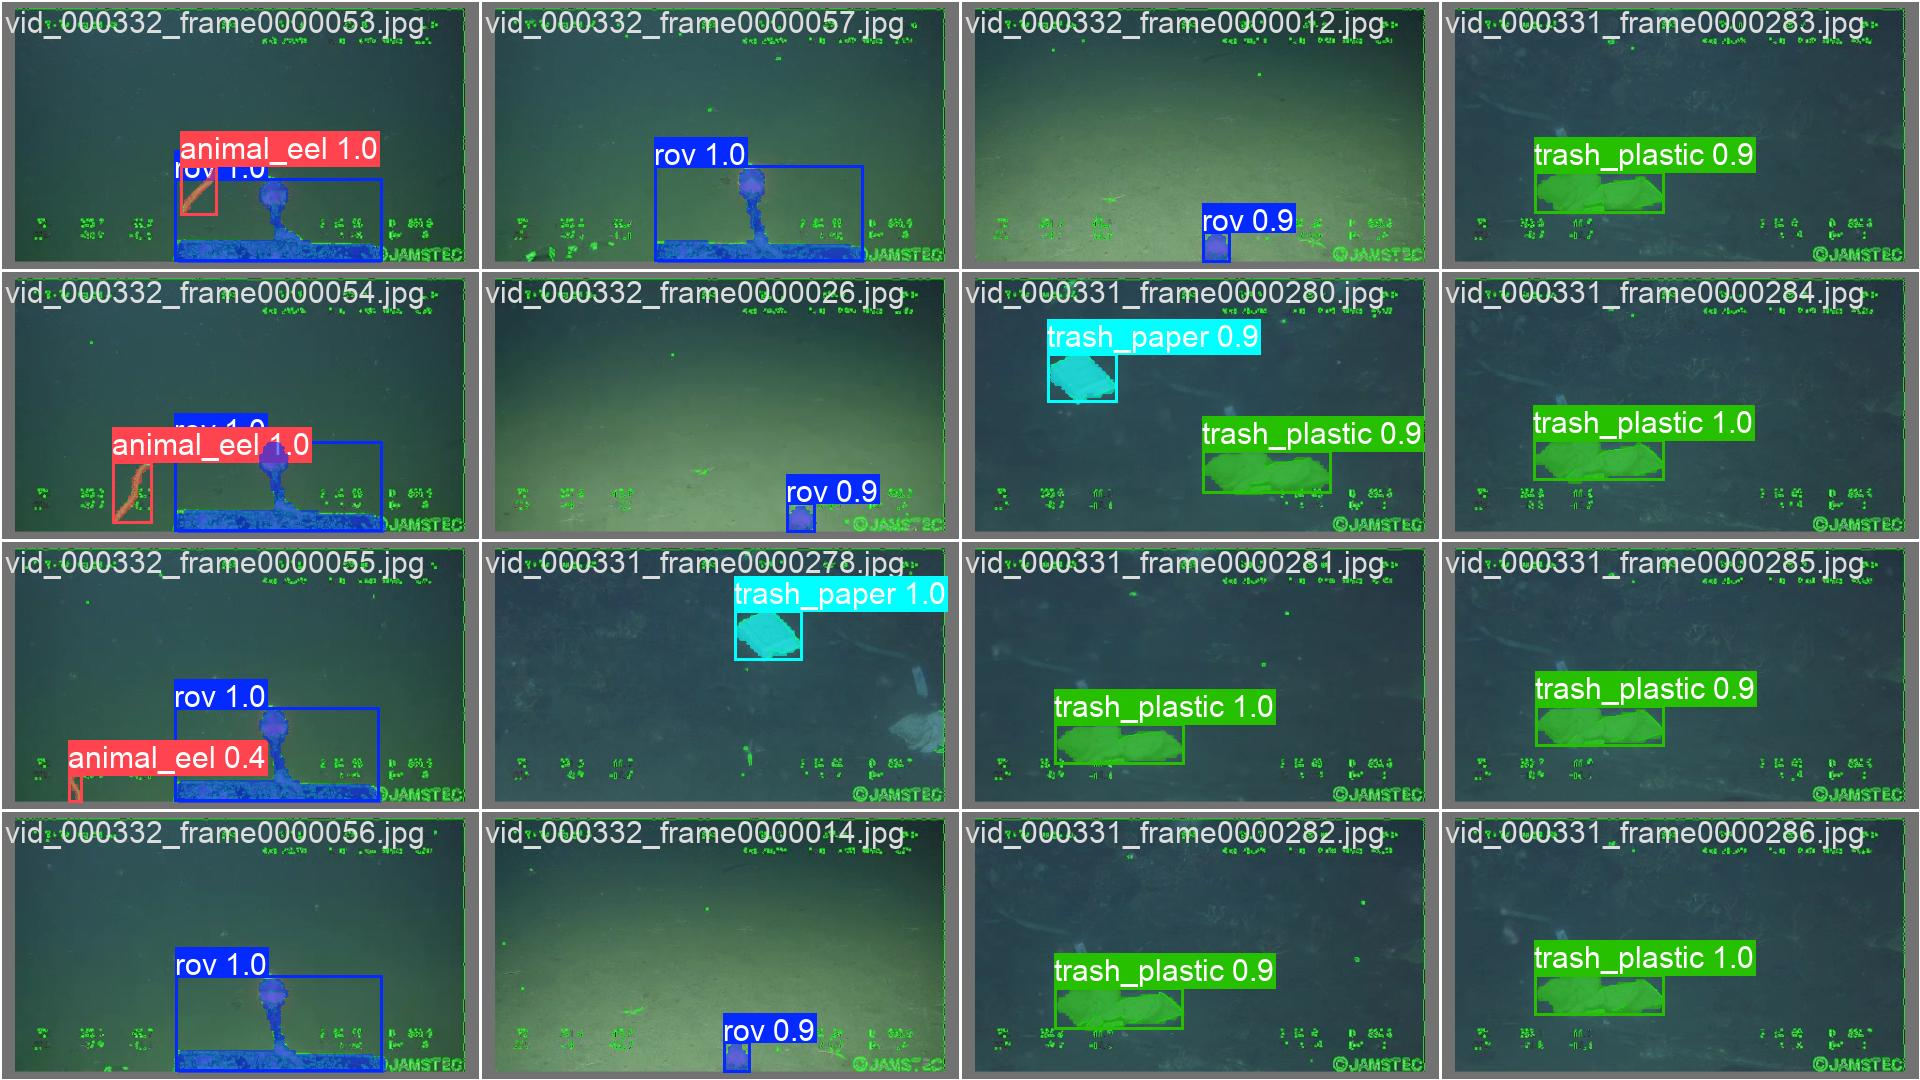

In [28]:
# Path to the PNG file
result_png_path = f"{HOME}/runs/segment/train23/val_batch2_pred.jpg"

# Display the PNG file
Image(result_png_path)

In [34]:
test_image = '../../data/material_version/train/vid_000002_frame0000022.jpg'

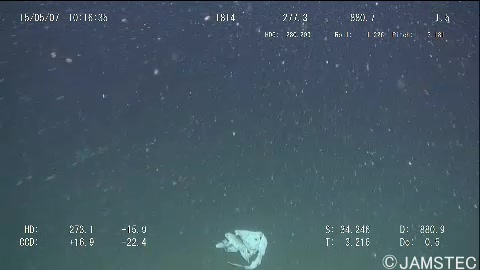

In [35]:
Image(test_image)

In [36]:
test_r = model(test_image)


image 1/1 c:\Users\ASUS\OneDrive\Desktop\marine-debris-detection\src\models\..\..\data\material_version\train\vid_000002_frame0000022.jpg: 288x480 1 trash_plastic, 71.1ms
Speed: 1.4ms preprocess, 71.1ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 480)


In [37]:
test_r[0].show()